In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, ELU, Flatten, Dense, Activation, Dropout, Lambda, Input, MaxPooling2D, Conv2D
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import time
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


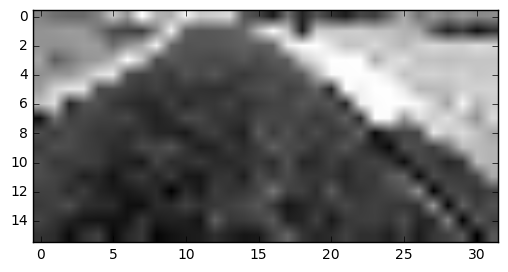

In [3]:
DATASET = "./dataset"
DATA_UDACITY = "udacity"
from model2 import *

image = os.path.join(DATASET, "exper/2.jpg")
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

shearMats = precomputeShearMat(320, 160, 60, 61, 2, 0.25, 1)

img = image[62:125, :, :]
img = img[:, 30:290]
#img = cv2.resize(img,(32,16))


img = cv2.cvtColor(cv2.resize(img,(32,16)), cv2.COLOR_RGB2HSV)
plt.imshow(img[:,:,2],cmap='gray')

#plt.imshow(img)
plt.show()

#img_center = cv2.resize(img_center, (image_columns, image_rows))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 14, 30, 2)     20          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 3, 7, 2)       0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 3, 7, 2)       0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 42)            0           dropout_1[0][0]                  
___________________________________________________________________________________________

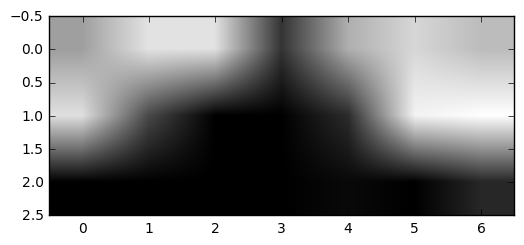

In [4]:
from keras.models import Model

with open("model.json", 'r') as jfile:
    model = model_from_json(jfile.read())
model.load_weights("model.h5")

def normalize_input(x):
    return x / 127.5 - 1.0

print(model.summary())

img2 = normalize_input(img[:,:,2]).reshape(1,16,32,1)

print(img2.shape)

layer_name = 'flatten_1'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)


intermediate_output = intermediate_layer_model.predict(img2)


r = intermediate_output.reshape(3,7,2)
print(intermediate_output.shape)
plt.imshow(r[:,:,1],cmap='gray')


import os
files = os.listdir("dataset/feed")
for i in range(len(files)):
    print(files[i])

In [14]:
import os
files = os.listdir("dataset/feed")
sorted(files)
pred = []
oryg = []
cnn = []
for i in range(len(files)):
    path = os.path.join("dataset/feed", files[i])
    image = cv2.imread(path)
    if image is not None:
        image = cv2.resize(image,(32,16))
        oryg.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image2 = (cv2.cvtColor(image, cv2.COLOR_BGR2HSV))[:,:,2]
        
        img2 = normalize_input(image2).reshape(1,16,32,1)
        intermediate_output = intermediate_layer_model.predict(img2)
        r = intermediate_output.reshape(3,7,2)
        vall = r[:,:,1]
        vall = cv2.resize(vall,(32,16))
        vall = (vall * 255 / np.max(vall))
        pr = cv2.cvtColor(vall, cv2.COLOR_GRAY2RGB)
        cnn.append(pr)
        
        image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2RGB)
        pred.append(image2)
        print(files[i])
    
from moviepy.editor import *
# a = pred
# 
# print(isinstance(a, list))
# print(isinstance(a[0], str))
# 
# print(np.min(cnn[4]))
# 
# 
# plt.imshow(cnn[3])

new_clip = ImageSequenceClip(pred, fps=10)
new_clip.write_videofile("preproc_pred.mp4")
 
new_clip = ImageSequenceClip(oryg, fps=10)
new_clip.write_videofile("preproc_oryg.mp4")

new_clip = ImageSequenceClip(cnn, fps=10)
new_clip.write_videofile("preproc_cnn.mp4")

center_2016_12_01_13_33_03_676.jpg
center_2016_12_01_13_33_03_776.jpg
center_2016_12_01_13_33_03_877.jpg
center_2016_12_01_13_33_03_979.jpg
center_2016_12_01_13_33_04_080.jpg
center_2016_12_01_13_33_04_182.jpg
center_2016_12_01_13_33_04_284.jpg
center_2016_12_01_13_33_04_385.jpg
center_2016_12_01_13_33_04_486.jpg
center_2016_12_01_13_33_04_588.jpg
center_2016_12_01_13_33_04_689.jpg
center_2016_12_01_13_33_04_789.jpg
center_2016_12_01_13_33_04_891.jpg
center_2016_12_01_13_33_04_992.jpg
center_2016_12_01_13_33_05_092.jpg
center_2016_12_01_13_33_05_194.jpg
center_2016_12_01_13_33_05_295.jpg
center_2016_12_01_13_33_05_396.jpg
center_2016_12_01_13_33_05_496.jpg
center_2016_12_01_13_33_05_599.jpg
center_2016_12_01_13_33_05_701.jpg
center_2016_12_01_13_33_05_802.jpg
center_2016_12_01_13_33_05_903.jpg
center_2016_12_01_13_33_06_005.jpg
center_2016_12_01_13_33_06_108.jpg
center_2016_12_01_13_33_06_209.jpg
center_2016_12_01_13_33_06_310.jpg
center_2016_12_01_13_33_06_411.jpg
center_2016_12_01_13

[MoviePy] Writing video preproc_pred.mp4


  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:00<00:00, 5443.79it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: preproc_pred.mp4 



[MoviePy] >>>> Building video preproc_oryg.mp4


[MoviePy] Writing video preproc_oryg.mp4



  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:00<00:00, 5297.65it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: preproc_oryg.mp4 



[MoviePy] >>>> Building video preproc_cnn.mp4


[MoviePy] Writing video preproc_cnn.mp4



  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:00<00:00, 5811.74it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: preproc_cnn.mp4 

